In [1]:
import os
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
import torchvision
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
from torchvision import transforms
from tqdm import tqdm
import warnings
import cv2
import torch.nn.functional as F
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings(action="ignore")
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dir = "./data/"
train_df = pd.read_csv(os.path.join(dir, "train.csv"))
dev_df = pd.read_csv(os.path.join(dir, "dev.csv"))

# label column 만들기
train_df["ST1_GAP(eV)"] = train_df["S1_energy(eV)"] - train_df["T1_energy(eV)"]
dev_df["ST1_GAP(eV)"] = dev_df["S1_energy(eV)"] - dev_df["T1_energy(eV)"]

# train_sdf 폴더로부터 데이터 받아와서 jpg로 저장
train_mols = []
trainpath = "./data/train_sdf/"
train_sdf = os.listdir(trainpath)
trainjpg = "./data/train_jpg/"

for data in tqdm(train_sdf):
    image = Chem.SDMolSupplier(trainpath + f"{data}")
    # none이 아니면 저장
    try: 
        mol = [m for m in image if m is not None][0]
        # jpg 파일로 변환하여 저장
        img = Draw.MolToImage(mol, size=(256, 256))
        img.save(trainjpg+f"{data.split('.')[0]}.jpg")
        train_mols.append(mol)
    # none이면 df에서 해당 index 삭제
    except:
        idx = train_df[train_df.uid==f"{data.split('.')[0]}"].index
        train_df.drop(index=idx, inplace=True)

# dev_sdf 폴더로부터 데이터 받아와서 jpg로 저장
dev_mols = []
devpath = "./data/dev_sdf/"
dev_sdf = os.listdir(devpath)
devjpg = "./data/dev_jpg/"

for data in tqdm(dev_sdf):
    image = Chem.SDMolSupplier(devpath + f"{data}")
    # none이 아니면 저장
    try: 
        mol = [m for m in image if m is not None][0]
        # jpg 파일로 변환하여 저장
        img = Draw.MolToImage(mol, size=(256, 256))
        img.save(devjpg+f"{data.split('.')[0]}.jpg")
        dev_mols.append(mol)
    # none이면 df에서 해당 index 삭제
    except:
        idx = dev_df[dev_df.uid==f"{data.split('.')[0]}"].index
        dev_df.drop(index=idx, inplace=True)

  2%|█▌                                                                            | 595/30274 [00:08<06:53, 71.69it/s][11:31:44] WARNING: not removing hydrogen atom without neighbors
[11:31:44] WARNING: not removing hydrogen atom without neighbors
 12%|█████████▌                                                                   | 3741/30274 [00:52<05:58, 73.93it/s][11:32:28] WARNING: not removing hydrogen atom without neighbors
[11:32:28] WARNING: not removing hydrogen atom without neighbors
[11:32:28] WARNING: not removing hydrogen atom without neighbors
[11:32:28] WARNING: not removing hydrogen atom without neighbors
 13%|█████████▉                                                                   | 3884/30274 [00:54<06:19, 69.45it/s][11:32:30] WARNING: not removing hydrogen atom without neighbors
[11:32:30] WARNING: not removing hydrogen atom without neighbors
 18%|█████████████▌                                                               | 5311/30274 [01:14<05:40, 73.39it/s][11:

In [11]:
# SMILES 토큰화
vocab_path = "./vocab.txt"
tokenizer = SmilesTokenizer(vocab_path)
max_len = train_df.SMILES.str.len().max()
seqs = []
for index in train_df.index:
    seq = tokenizer.encode(train_df.loc[index, "SMILES"])
    seq = torch.Tensor(seq)
    seq = F.pad(seq, (0, max_len-len(seq)))
    seqs.append(seq)
seqs = torch.stack(seqs)

# imgs, labels 설정
img_dir = "./data/train_jpg/"
img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
labels = train_df["ST1_GAP(eV)"].to_numpy()

# shuffle 후 train, val 나누기
img_paths, seqs, labels = shuffle(img_paths, seqs, labels, random_state=42)
train_imgs = img_paths[:25000]
train_seqs = seqs[:25000]
train_labels = labels[:25000]
val_imgs = img_paths[25000:]
val_seqs = seqs[25000:]
val_labels = labels[25000:]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [12]:
# 이미지 데이터셋 전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)), # 입력 이미지를 크기 resize로 조정, 입력 이미지의 임의의 면적(scale)을 무작위로 자름
                transforms.RandomHorizontalFlip(), # 50% 확률로 이미지를 수평 반전
                transforms.ToTensor(),
                transforms.Normalize(mean, std) # ImageNet 데이터의 각 채널별 평균과 표준편차에 맞춰 정규화
            ]),
            "val": transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "test": transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
        }
    
    def __call__(self, img, mode): # 클래스를 호출할 수 있도록 하는 메서드
        return self.data_transform[mode](img)
    
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [13]:
class CustomDataset(Dataset):
    def __init__(self, imgs_path, seqs, transform=None, labels=None, mode="train"):
        self.mode = mode
        self.imgs_path = imgs_path
        self.transform = transform
        self.seqs = seqs
        # train에만 label 들어가게끔 지정
        if self.mode == "train" or "val":
            self.labels = labels
            
    def __len__(self):
        return len(self.imgs_path)
    
    def __getitem__(self, idx):
        img_path = self.imgs_path[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.mode)

        if self.mode == "test":
            return {
                "img" : img_transformed,
                "seq" : torch.tensor(self.seqs[idx], dtype=torch.int64),
            }
        elif self.mode == "train" or "val":
            return {
                "img" : img_transformed,
                "seq" : torch.tensor(self.seqs[idx], dtype=torch.int64),
                "label" : torch.tensor(self.labels[idx], dtype=torch.float32)
            }

In [14]:
# dataset 정의
train_dataset = CustomDataset(train_imgs, train_seqs, transform=ImageTransform(size, mean, std), labels=train_labels, mode="train")
val_dataset = CustomDataset(val_imgs, val_seqs, transform=ImageTransform(size, mean, std), labels=val_labels, mode="val")

# dataloader 정의
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# hyperparameters 설정
dropout_rate = 0.2
embedding_dim = 128
learning_rate = 1e-4

In [16]:
# Resnet50 model
class Encoder(nn.Module):
    def __init__(self, embedding_dim, dropout_rate):
        super(Encoder, self).__init__()
        model = models.resnet50(pretrained=True)
        features = list(model.children())[:-2]
        self.feature = nn.Sequential(*features)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Sequential(
            nn.Linear(2048, embedding_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate))

    def forward(self, x):
        x = self.feature(x)
        x = x.permute(0, 2, 3, 1)
        x = x.view(x.size(0), -1, x.size(3))
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [17]:
# LSTM model
class Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, dropout_rate):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(2*max_len, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim*(max_len+64), 1),
            nn.ReLU(inplace=True))

    def forward(self, enc_output, dec_input):
        x = self.embedding(dec_input)
        x = self.dropout(x)
        x = torch.cat([enc_output, x], dim=1)
        x, _ = self.lstm(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [18]:
# encoder와 decoder 연결
class CNN2RNN(nn.Module):
    def __init__(self, embedding_dim, max_len, dropout_rate):
        super(CNN2RNN, self).__init__()
        self.encoder = Encoder(embedding_dim, dropout_rate)
        self.decoder = Decoder(max_len, embedding_dim, dropout_rate)
        
    def forward(self, img, seq):
        enc_output = self.encoder(img)
        output = self.decoder(enc_output, seq)
        return output
     
model = CNN2RNN(embedding_dim=embedding_dim, max_len=max_len, dropout_rate=dropout_rate)
model = model.to(device)

In [19]:
# optimizer, loss function 정의
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
criterion = criterion.to(device)

In [20]:
def train_model(item, epoch, batch, training):
    img = item['img'].to(device)
    seq = item['seq'].to(device)
    label = item['label'].to(device)
    
    # 모델 훈련할 때
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.set_grad_enabled(mode=True):
            output = model(img, seq)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()

    # 모델 검증할 때
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, seq)
            loss = criterion(output, label)
            
    return loss

In [26]:
# 모델 저장 경로
save_path = './best_model.pt'

# 학습 중 train loss, val loss 변화 알아보기 위해 list 생성
train_loss_plot, val_loss_plot = [], []
epochs = 20

for epoch in range(epochs):
    # 매 epoch가 시작할 때 loss 초기화
    total_train_loss, total_val_loss = 0.0, 0.0
    
    # train loss 구하기
    dataset_train = tqdm(enumerate(train_dataloader))
    training = True
    for batch, item in dataset_train:
        batch_train_loss = train_model(item, epoch, batch, training)
        total_train_loss += batch_train_loss
        
        # 진행 상황 print
        dataset_train.set_postfix({
            'Epoch': f"{epoch + 1}",
            'Batch Train Loss': f"{batch_train_loss.item():06f}",
            'Total Train Loss' : f"{total_train_loss/(batch+1):06f}"
        })
    train_loss_plot.append(total_train_loss/(batch+1))
    
    # validation loss 구하기
    dataset_val = tqdm(enumerate(val_dataloader))
    training = False
    for batch, item in dataset_val:
        batch_val_loss = train_model(item, epoch, batch, training)
        total_val_loss += batch_val_loss
        
        # 진행 상황 print
        dataset_val.set_postfix({
            'Epoch': f"{epoch + 1}",
            'Batch Val Loss': f"{batch_val_loss.item():06f}",
            'Total Val Loss' : f"{total_val_loss/(batch+1):06f}"
        })
    val_loss_plot.append(total_val_loss/(batch+1))

    # 5 epoch마다 checkpoint 저장
    if (epoch+1) % 5 == 0:
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch,
            "loss": total_train_loss/batch
        }, f"./checkpoint_{epoch+1}.tar")
    
    # 최적 모델 저장
    if min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

1563it [16:23,  1.59it/s, Epoch=1, Batch Train Loss=0.034410, Total Train Loss=0.140526]
330it [01:19,  4.17it/s, Epoch=1, Batch Val Loss=0.148580, Total Val Loss=0.137067]
1563it [15:05,  1.73it/s, Epoch=2, Batch Train Loss=0.084875, Total Train Loss=0.136353]
330it [01:02,  5.32it/s, Epoch=2, Batch Val Loss=0.141302, Total Val Loss=0.135408]
1563it [15:18,  1.70it/s, Epoch=3, Batch Train Loss=0.221693, Total Train Loss=0.135921]
330it [01:04,  5.09it/s, Epoch=3, Batch Val Loss=0.151825, Total Val Loss=0.140127]
1563it [15:39,  1.66it/s, Epoch=4, Batch Train Loss=0.066138, Total Train Loss=0.134584]
330it [01:10,  4.67it/s, Epoch=4, Batch Val Loss=0.141208, Total Val Loss=0.135023]
1563it [16:21,  1.59it/s, Epoch=5, Batch Train Loss=0.158395, Total Train Loss=0.134313]
330it [01:19,  4.15it/s, Epoch=5, Batch Val Loss=0.140666, Total Val Loss=0.135212]
1563it [17:17,  1.51it/s, Epoch=6, Batch Train Loss=0.205535, Total Train Loss=0.134567]
330it [01:30,  3.64it/s, Epoch=6, Batch Val Lo

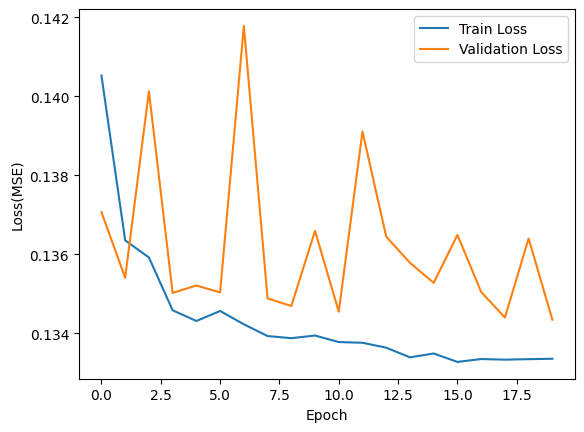

In [27]:
# train loss와 validation loss 시각화
plt.plot(torch.stack(train_loss_plot).cpu().detach(), label='Train Loss')
plt.plot(torch.stack(val_loss_plot).cpu(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss(MSE)')
plt.legend()
plt.show()

In [28]:
# 최적 모델 불러오기
save_path = './best_model.pt'
best_model = torch.load(save_path, map_location=device)
print(best_model)

CNN2RNN(
  (encoder): Encoder(
    (feature): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          

In [29]:
# test dataset 불러오기
dir = "./data/"
test_df = pd.read_csv(os.path.join(dir, "test.csv"))

# train_sdf 폴더로부터 데이터 받아와서 jpg로 저장
test_mols = []
testpath = "./data/test_sdf/"
test_sdf = os.listdir(testpath)
testjpg = "./data/test_jpg/"

for data in tqdm(test_sdf):
    image = Chem.SDMolSupplier(testpath + f"{data}")
    # none이 아니면 저장
    try: 
        mol = [m for m in image if m is not None][0]
        # jpg 파일로 변환하여 저장
        img = Draw.MolToImage(mol, size=(256, 256))
        img.save(testjpg+f"{data.split('.')[0]}.jpg")
        test_mols.append(mol)
    # none이면 df에서 해당 index 삭제
    except:
        idx = test_df[test_df.uid==f"{data.split('.')[0]}"].index
        test_df.drop(index=idx, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████| 602/602 [00:38<00:00, 15.79it/s]


In [30]:
test_df

,uid,SMILES
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)...
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(...
3,test_3,CCCn1c(=O)c2ccccc2n2c(SCC(=O)NC(Cc3ccccc3)c3cc...
4,test_4,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cn...
...,...,...
597,test_597,N#Cc1c(-n2c3ccccc3c3ccccc32)c(-n2c3ccccc3c3ccc...
598,test_598,CC1(C)c2ccccc2N(c2ccc(-c3cc(-c4ccc(N5c6ccccc6C...
599,test_599,Cc1nc(-c2ccc(N3c4ccccc4C(C)(C)c4ccccc43)cc2)cc...
600,test_600,c1ccc2c(c1)Oc1ccccc1N2c1ccc(-c2nc3ccccc3s2)cc1


In [31]:
# SMILES 토큰화
vocab_path = "./vocab.txt"
tokenizer = SmilesTokenizer(vocab_path)
max_len = train_df.SMILES.str.len().max()
test_seqs = []
for index in test_df.index:
    seq = tokenizer.encode(test_df.loc[index, "SMILES"])
    seq = torch.Tensor(seq)
    seq = F.pad(seq, (0, max_len-len(seq)))
    test_seqs.append(seq)
test_seqs = torch.stack(test_seqs)

# imgs 설정
test_img_dir = "./data/test_jpg/"
test_img_paths = sorted([os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)])


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [32]:
# test dataset 정의
test_dataset = CustomDataset(test_img_paths, test_seqs, transform=ImageTransform(size, mean, std), labels=None, mode="test")

# dataloader 정의
batch_size = 16
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [33]:
# 모델로 예측
def predict(dataset):
    best_model.eval()
    result = []
    for batch_item in dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['seq'].to(device)
        with torch.no_grad():
            output = best_model(img, seq)
        result.extend(output)
        
    return result
pred = predict(test_dataloader)

In [34]:
submission = pd.read_csv('./data/sample_submission.csv')
submission["ST1_GAP(eV)"] = torch.stack(pred).cpu()
submission

,uid,ST1_GAP(eV)
0,test_0,0.858018
1,test_1,0.815005
2,test_2,0.867976
3,test_3,0.843812
4,test_4,0.851704
...,...,...
597,test_597,0.805888
598,test_598,0.829147
599,test_599,0.794394
600,test_600,0.843809


In [35]:
submission.to_csv('dacon_submission.csv', index=False)

In [36]:
ss = pd.read_csv('./data/sample_submission.csv')
ss

,uid,ST1_GAP(eV)
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0
...,...,...
597,test_597,0
598,test_598,0
599,test_599,0
600,test_600,0


In [38]:
test_df

,uid,SMILES
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)...
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(...
3,test_3,CCCn1c(=O)c2ccccc2n2c(SCC(=O)NC(Cc3ccccc3)c3cc...
4,test_4,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cn...
...,...,...
597,test_597,N#Cc1c(-n2c3ccccc3c3ccccc32)c(-n2c3ccccc3c3ccc...
598,test_598,CC1(C)c2ccccc2N(c2ccc(-c3cc(-c4ccc(N5c6ccccc6C...
599,test_599,Cc1nc(-c2ccc(N3c4ccccc4C(C)(C)c4ccccc43)cc2)cc...
600,test_600,c1ccc2c(c1)Oc1ccccc1N2c1ccc(-c2nc3ccccc3s2)cc1


In [37]:
ss_result = pd.read_csv("dacon_submission.csv")
ss_result

,uid,ST1_GAP(eV)
0,test_0,0.848268
1,test_1,0.829157
2,test_2,0.835896
3,test_3,0.825597
4,test_4,0.836732
...,...,...
597,test_597,0.782400
598,test_598,0.787167
599,test_599,0.812540
600,test_600,0.826216
